# Feature Evolution with Phase

This notebook explores the evolution of feature properties (e.g., pEW and velocities) as a function of phase.


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from utils import read_in_pipeline_result


In [2]:
curr_dir = Path('.').resolve() 
config_path = curr_dir.parent / 'app_config.yml'
results_dir = curr_dir.parent / 'results'


In [3]:
feature_alias = {
    'pW1': 'Ca ii H&K',
    'pW2': 'Si ii λ4130',
    'pW3': 'Mg ii, Fe ii',
    'pW4': 'Fe ii, Si ii',
    'pW5': 'S ii λ5449, λ5622',
    'pW6': 'Si ii λ5972',
    'pW7': 'Si ii λ6355',
    'pW8': 'Ca ii IR triplet'}


In [4]:
def plot_branch_classifications(pipeline_data, phase_cutoff=7, figsize=(10, 10)):
    """Create a Branch classification figure
    
    Args:
        pipeline_data (DataFrame): Data that has been read from a pipeline output file
        phase_cutoff      (float): Only use measurements taken within so many days of peak brightness
        fig_size          (Tuple): Size of the figure in inches
    """
    
    fig, axis = plt.subplots(figsize=figsize)
    
    plot_args = {
        'CL': dict(label='Cool', color='blue', marker='s'),
        'BL': dict(label='Broad Line', color='red' , marker='^'),
        'SS': dict(label='Shallow Silicon', color='green' , marker= '*'),
        'CN': dict(label='Core Normal', color='black' , marker= '.')
    }
    peak_vals = pipeline_data[pipeline_data.is_peak]
    peak_vals = peak_vals[peak_vals.delta_t <= phase_cutoff]
    
    pw6_data = peak_vals[['pew', 'pew_samperr', 'branch_type']].loc['pW6']
    all_data = pw6_data.join(peak_vals[['pew', 'pew_samperr']].loc['pW7'], lsuffix='_6', rsuffix='_7').dropna()

    for branch_class, data in all_data.groupby('branch_type'):
        label = plot_args[branch_class].pop('label') + f' ({len(data)})'
        axis.errorbar(
            data.pew_7, 
            data.pew_6, 
            xerr=data.pew_samperr_7,
            yerr=data.pew_samperr_6,
            linestyle='',
            label=label,
            **plot_args.get(branch_class, dict()))
    
    plt.title('Strength of pW6 vs pW7')
    axis.legend(loc = ('upper left'))
    plt.xlabel('pew of pW7')
    plt.ylabel('pew of pW6')
    

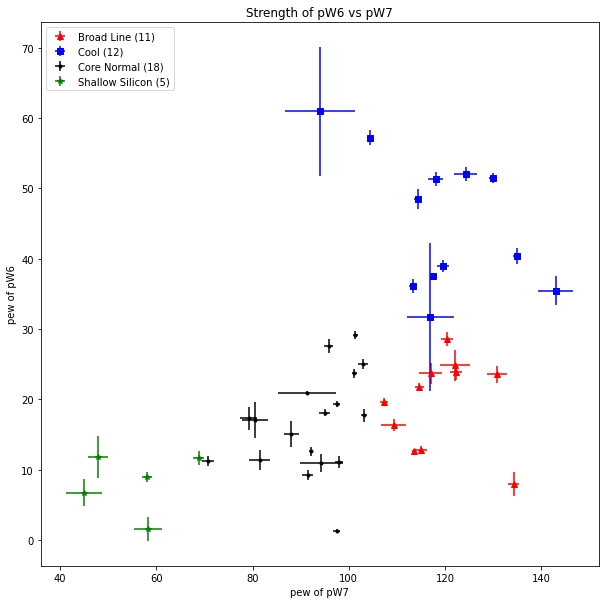

In [5]:
csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', 'csp', drop_flagged=True)
plot_branch_classifications(csp_final)


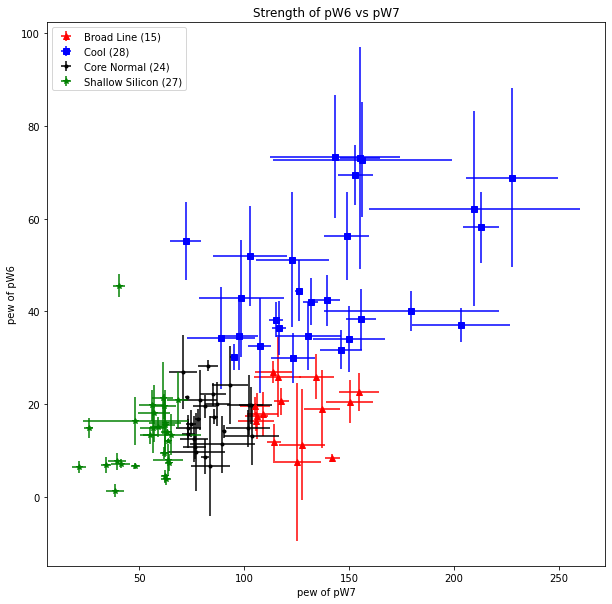

In [6]:
sdss_final = read_in_pipeline_result(results_dir / 'final_sdss.csv', 'sdss', drop_flagged=True)
plot_branch_classifications(sdss_final)
